In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats as scs
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
%config InlineBackend.figure_format = 'retina'

In [2]:
data_filename = "https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv"#"data/us-states.csv"

df = pd.read_csv(data_filename)
df["date"] = pd.to_datetime(df["date"])

In [3]:
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [4]:
state_pop_df = pd.read_csv("data/state_pop.csv", skiprows=1)
state_pop_df["fips"] = state_pop_df["id"].str[-2:].astype(int)

In [5]:
df.head()

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0


In [28]:
TEST_LAG = 8
DEATH_LAG = 18
DETECTION_PROB = 1/8
DEATH_PROB = 1/50
STATE_FIPS = 53

CASES_MIN = 300
DEATH_MIN = 10
TEST_TRUSTWORTHY_START = 50
DEATH_TRUSTWORTHY_START = 46

STATE = "Washington"

df_state = df[df.state==STATE]

date0 = df_state.iloc[0].date

case_plot = df_state[ df_state.cases >= CASES_MIN ]
death_plot = df_state[ df_state.deaths >= DEATH_MIN ]

test_day = (case_plot.date-date0).dt.days-TEST_LAG
test_results = case_plot.cases/DETECTION_PROB

death_day = (death_plot.date-date0).dt.days-DEATH_LAG
death_results = death_plot.deaths/DEATH_PROB

(1, 1000000)

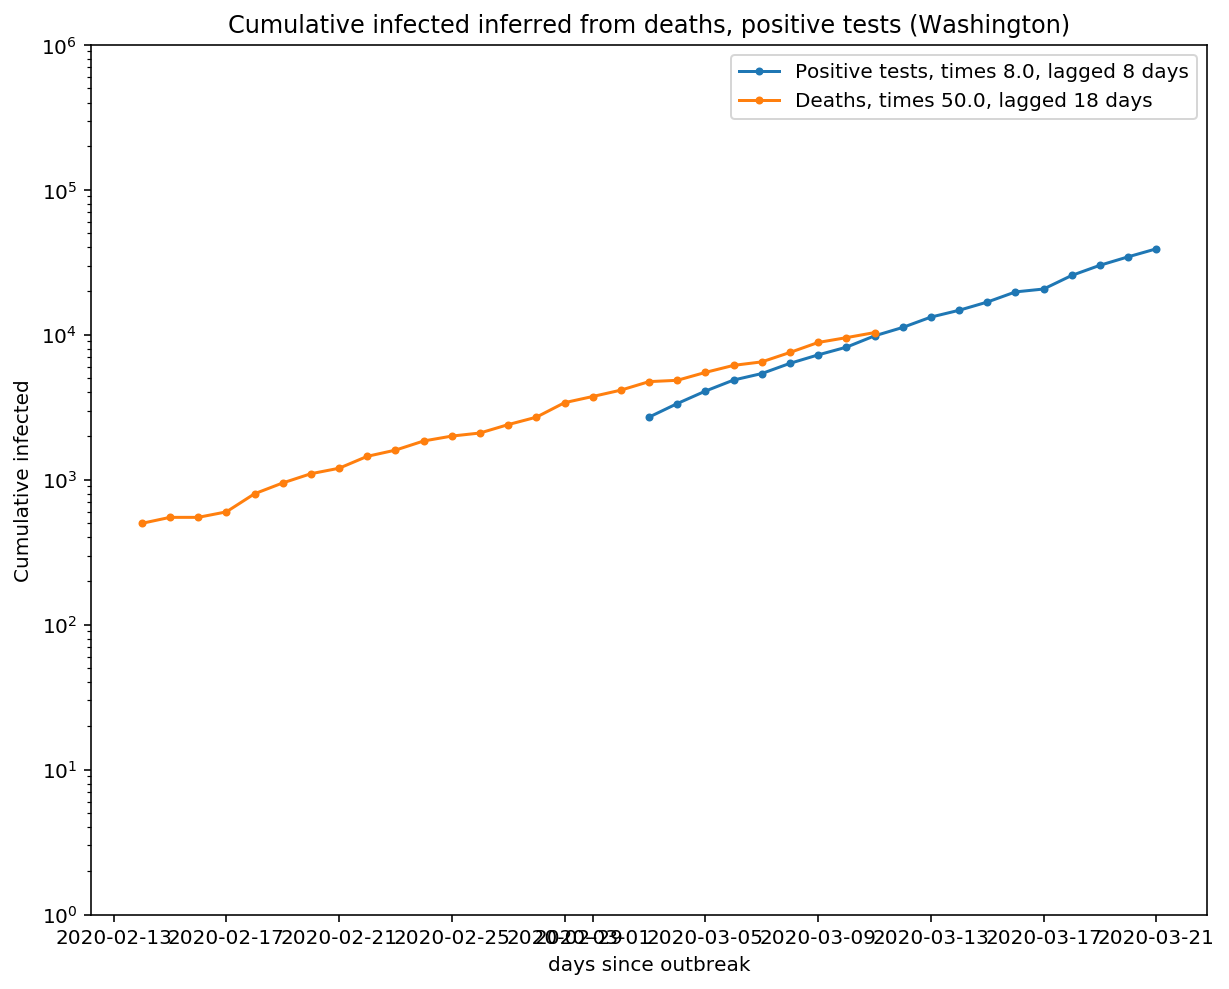

In [29]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Cumulative infected inferred from deaths, positive tests (%s)"%STATE)
ax.plot( date0+test_day*timedelta(days=1), 
        test_results, label="Positive tests, times %s, lagged %s days"%(1/DETECTION_PROB, TEST_LAG), marker="." )
ax.plot( date0+death_day*timedelta(days=1), 
        death_results, label="Deaths, times %s, lagged %s days"%(1/DEATH_PROB, DEATH_LAG), marker="." )
ax.set_xlabel("days since outbreak")
ax.set_ylabel("Cumulative infected")
ax.legend()
ax.semilogy()
ax.set_ylim(1,1000000)

In [30]:
all_days = np.concatenate( [test_day, death_day] )
all_results = np.concatenate( [test_results, death_results] )

In [31]:
def add_one(ary):
    """Input: 1-d array
    Output: 2d array, 0th column all 1s."""
    
    return np.vstack((np.ones_like(ary),ary)).T

class LoglinearModel:
        
    def fit(self, x, y):
        X = sm.add_constant(x)
        
        mod = sm.OLS(np.log(y), X)
        res = mod.fit()
        
        self.params = res.params
        self.cov = res.cov_params()
    
    def __call__(self, x):
        return np.exp(add_one(x) @ self.params )
    
    def sample(self, x, n_samples=100):
        norm = scs.multivariate_normal(mean=self.params, cov=self.cov)
        param_samples = norm.rvs(n_samples)
        
        return np.exp(add_one(x) @ param_samples.T)

In [32]:
today_days = (pd.to_datetime( datetime.today() ) - date0).days
today_days

69

In [33]:
infection_pred = LoglinearModel()
infection_pred.fit( all_days, all_results )

(array([  2.,   0.,   4.,  14.,  28.,  45., 102., 137., 165., 290., 326.,
        380., 412., 455., 487., 432., 379., 345., 291., 218., 151., 117.,
         88.,  51.,  23.,  25.,  14.,  11.,   4.,   4.]),
 array([ 79492.56304543,  80723.81819558,  81955.07334573,  83186.32849588,
         84417.58364603,  85648.83879618,  86880.09394633,  88111.34909648,
         89342.60424663,  90573.85939678,  91805.11454693,  93036.36969708,
         94267.62484723,  95498.87999738,  96730.13514753,  97961.39029768,
         99192.64544784, 100423.90059799, 101655.15574814, 102886.41089829,
        104117.66604844, 105348.92119859, 106580.17634874, 107811.43149889,
        109042.68664904, 110273.94179919, 111505.19694934, 112736.45209949,
        113967.70724964, 115198.96239979, 116430.21754994]),
 <a list of 30 Patch objects>)

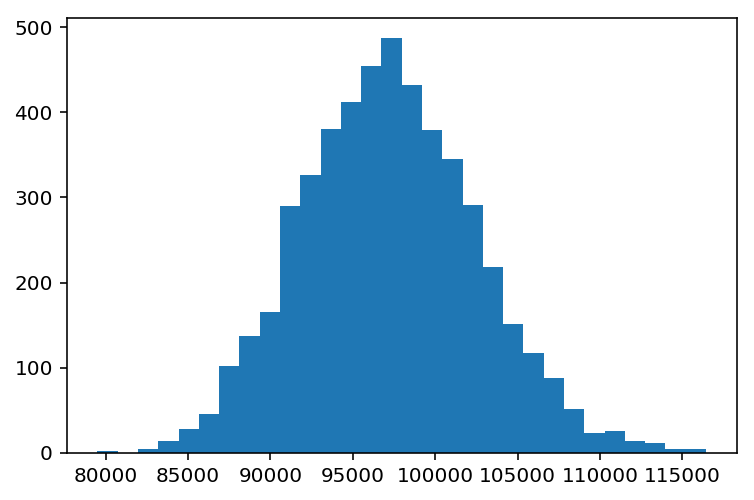

In [34]:
plt.hist( infection_pred.sample(today_days, n_samples=5000)[0], bins=30 )

In [35]:
infection_pred(today_days)

array([97184.55312681])

[]

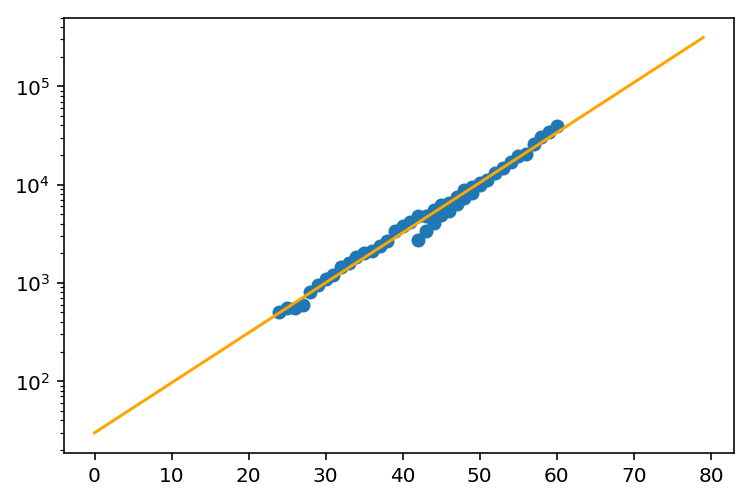

In [36]:
dayspace = np.arange(0,80)


plt.scatter( all_days, all_results )
plt.plot( dayspace, infection_pred(dayspace), c="orange" )
plt.semilogy()

In [37]:
dayspace = np.arange(-5,80)

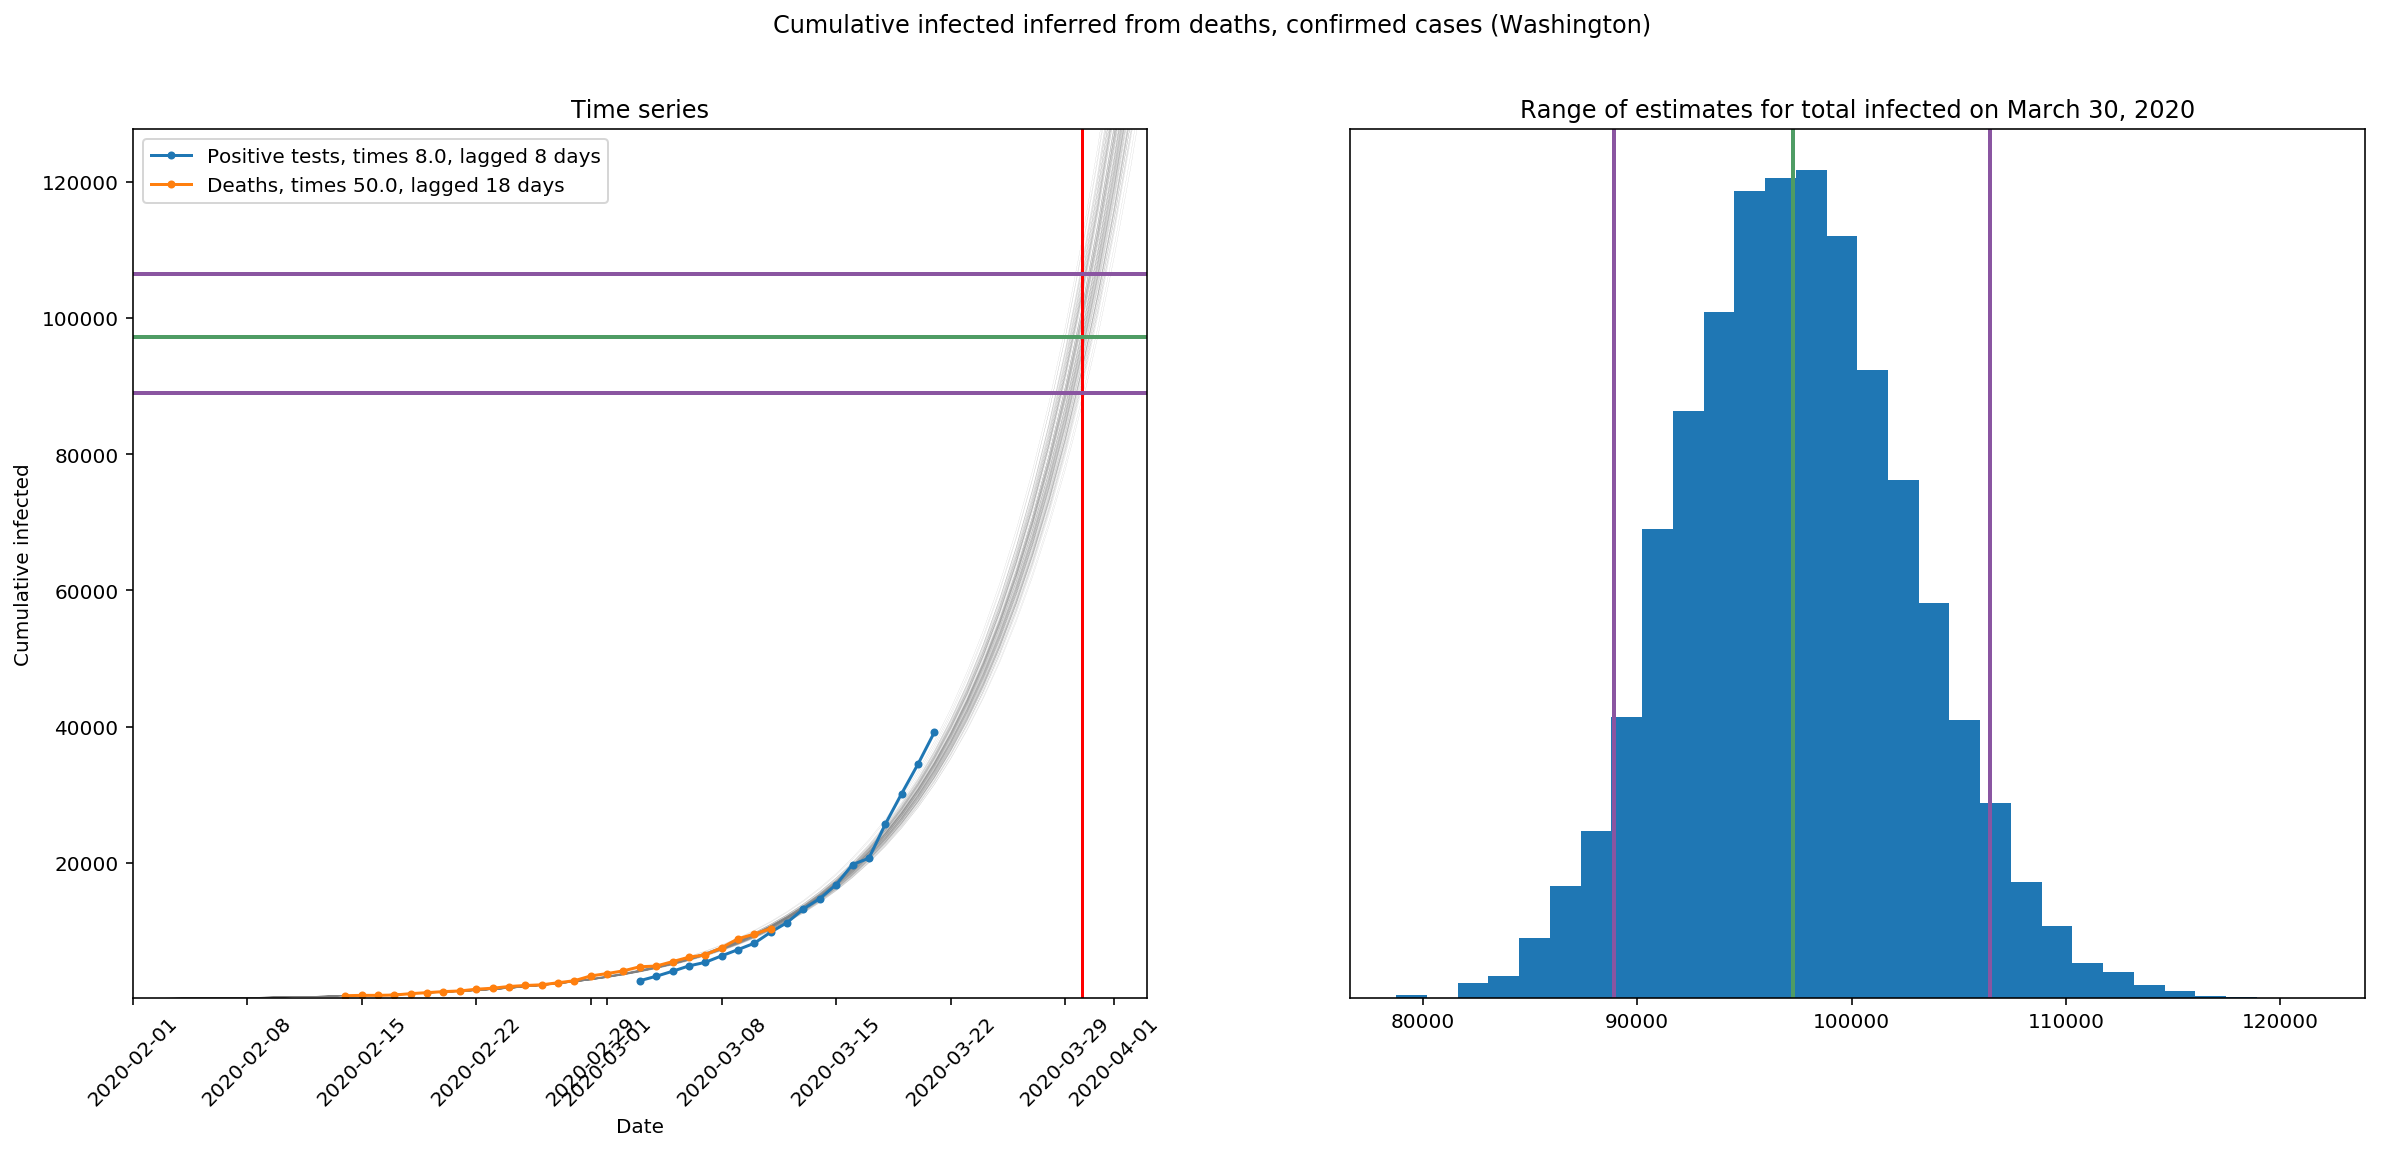

In [90]:
TODAY = "March 30, 2020"
OUTER_EST_COLOR = "#8a55a1"
MEDIAN_EST_COLOR = "#4f9c64"
N_SAMPLES = 10000

total_infected_samples = infection_pred.sample(today_days, n_samples=N_SAMPLES)[0]
est_low, est_med, est_high = np.percentile( total_infected_samples, [5, 50, 95])

fig, axs = plt.subplots(1, 2, figsize=(20,8))

ax = axs[0]

for tick in ax.get_xticklabels():
    tick.set_rotation(45)

ax.set_title("Time series")

for trace in infection_pred.sample(dayspace).T:
    ax.plot(date0+dayspace*timedelta(days=1), trace, c="gray", lw=0.05)


ax.plot( date0+test_day*timedelta(days=1), 
        test_results, label="Positive tests, times %s, lagged %s days"%(1/DETECTION_PROB, TEST_LAG), marker="." )
ax.plot( date0+death_day*timedelta(days=1), 
        death_results, label="Deaths, times %s, lagged %s days"%(1/DEATH_PROB, DEATH_LAG), marker="." )

ax.set_xlabel("Date")
ax.set_ylabel("Cumulative infected")
ax.legend()
#ax.semilogy()
ax.set_ylim(100,est_high*1.2)
ax.set_xlim("February 1, 2020", "April 3, 2020")

ax.axvline(TODAY, c="red")
ax.axhline(est_low, c=OUTER_EST_COLOR, lw=2)
ax.axhline(est_med, c=MEDIAN_EST_COLOR, lw=2)
ax.axhline(est_high, c=OUTER_EST_COLOR, lw=2)


ax = axs[1]
today_days = (pd.to_datetime( datetime.today() ) - date0).days
today_days
ax.hist( total_infected_samples, bins=30, density=True )
ax.set_yticks([])
ax.set_title("Range of estimates for total infected on %s"%TODAY)
ax.axvline(est_low, c=OUTER_EST_COLOR, lw=2)
ax.axvline(est_med, c=MEDIAN_EST_COLOR, lw=2)
ax.axvline(est_high, c=OUTER_EST_COLOR, lw=2)

plt.suptitle("Cumulative infected inferred from deaths, confirmed cases (%s)"%STATE)

None